<a href="https://colab.research.google.com/github/Haebuk/Python_Machine_Learning/blob/master/Pytorch_TransferLearning_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

#데이터 불러오기
데이터를 불러오기 위해 torchvision과 torch.utils.data 패키지를 사용하겠습니다.

여기서 풀고자 하는 문제는 개미 와 벌 을 분류하는 모델을 학습하는 것입니다. 개미와 벌 각각의 학습용 이미지는 대략 120장 정도 있고, 75개의 검증용 이미지가 있습니다. 일반적으로 맨 처음부터 학습을 한다면 이는 일반화하기에는 아주 작은 데이터셋입니다. 하지만 우리는 전이학습을 할 것이므로, 일반화를 제법 잘 할 수 있을 것입니다.

이 데이터셋은 ImageNet의 아주 작은 일부입니다.

In [ ]:
# 학습을 위한 데이터 augmentation 및 normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/input/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#일부 이미지 시각화

데이터 증가를 이해하기 위해 일부 학습용 이미지를 시각화

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


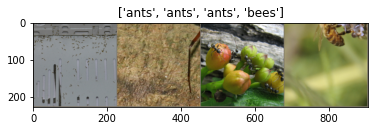

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

#모델 학습하기
이제 모델을 학습하기 위한 일반 함수를 작성해보겠습니다. 여기서는 다음 내용들을 설명합니다:

- 학습률(learning rate) 관리(scheduling)
- 최적의 모델 구하기

아래에서 scheduler 매개변수는 torch.optim.lr_scheduler 의 LR 스케쥴러 객체(Object)입니다.

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 각 에폭은 학습 단계와 검증 단계 갖습니다
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # 모델을 학습 모드로 설정
            else:
                model.eval() # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

#모델 예측값 시각화하기
일부 이미지에 대한 예측값을 보여주는 일반화된 함수입니다.

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

#합성곱 신경망 미세조정(finetuning)
미리 학습한 모델을 불러온 후 마지막의 완전히 연결된 계층을 초기화합니다.

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있습니다.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


#학습 및 평가하기
CPU에서는 15-25분 가량, GPU에서는 1분도 이내의 시간이 걸립니다.

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.2616 Acc: 0.8893
val Loss: 0.2971 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.3341 Acc: 0.8566
val Loss: 0.2820 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.2929 Acc: 0.8893
val Loss: 0.3401 Acc: 0.8954

Epoch 3/24
----------
train Loss: 0.3254 Acc: 0.8525
val Loss: 0.2922 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.2838 Acc: 0.8770
val Loss: 0.2903 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.3023 Acc: 0.8648
val Loss: 0.2944 Acc: 0.9150

Epoch 6/24
----------
train Loss: 0.2905 Acc: 0.8811
val Loss: 0.2900 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.2884 Acc: 0.8607
val Loss: 0.2908 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.2845 Acc: 0.8607
val Loss: 0.2965 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3253 Acc: 0.8689
val Loss: 0.2844 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3598 Acc: 0.8689
val Loss: 0.2832 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.2449 Acc: 0.8852
val Loss: 0.2872 Acc: 0.9216

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


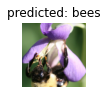

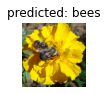

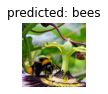

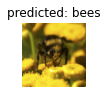

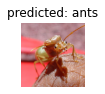

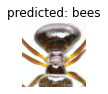

In [ ]:
visualize_model(model_ft)

# 고정된 특징 추출기로써의 합성곱 신경망
이제, 마지막 계층을 제외한 신경망의 모든 부분을 고정해야 합니다. requires_grad == False 로 설정하여 매개변수를 고정하여 backward() 중에 경사도가 계산되지 않도록 해야합니다.



In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# 새로 생성된 모듈의 매개변수는 기본값이 requires_grad=True 임
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# 이전과는 다르게 마지막 계층의 매개변수들만 최적화되는지 관찰
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5574 Acc: 0.6762
val Loss: 0.2528 Acc: 0.9085

Epoch 1/24
----------
train Loss: 0.4795 Acc: 0.7295
val Loss: 0.4573 Acc: 0.7843

Epoch 2/24
----------
train Loss: 0.5289 Acc: 0.7705
val Loss: 0.1898 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.5330 Acc: 0.7910
val Loss: 0.2052 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.5406 Acc: 0.7951
val Loss: 0.2096 Acc: 0.9216

Epoch 5/24
----------
train Loss: 0.3555 Acc: 0.8484
val Loss: 0.1767 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.3465 Acc: 0.8156
val Loss: 0.2253 Acc: 0.9085

Epoch 7/24
----------
train Loss: 0.3865 Acc: 0.8443
val Loss: 0.2204 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.2795 Acc: 0.8770
val Loss: 0.2007 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.4176 Acc: 0.8566
val Loss: 0.1962 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.2908 Acc: 0.8484
val Loss: 0.2055 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3260 Acc: 0.8893
val Loss: 0.1914 Acc: 0.9477

Epoch 12/24
----------
t